In [40]:
import pandas as pd
from dotenv import load_dotenv
import os
import psycopg2
from contextlib import contextmanager
import psycopg2
import numpy as np
import psycopg2.extras as extras

load_dotenv()

True

In [4]:
df = pd.read_csv("../data/candidates.csv", sep=";")

In [5]:
df.sample(3)

,First Name,Last Name,Email,Application Date,Country,YOE,Seniority,Technology,Code Challenge Score,Technical Interview Score
44426,Lexie,Lakin,amber11@hotmail.com,2021-04-16,Jordan,8,Junior,Development - FullStack,7,1
38174,Shyanne,Ondricka,mia_jacobs45@hotmail.com,2020-10-10,Botswana,16,Intern,QA Manual,5,2
38409,Angus,Farrell,eleazar.toy94@yahoo.com,2018-05-30,Jersey,2,Architect,Sales,1,0


In [49]:
# Database part
@contextmanager
def get_postgres_cnx() -> psycopg2.connect:
    try:
        cnx = psycopg2.connect(
            dbname="fullstack",
            user="balthapaixao",  # os.getenv("DE_POSTGRES_USER"),
            password=os.getenv("DE_POSTGRES_PASSWORD"),
            host="localhost",
            port=5432,
        )
        yield cnx
    finally:
        cnx.close()


def execute_values(conn: psycopg2.connect, df: pd.DataFrame, table: str):
    tuples = [tuple(x) for x in df.to_numpy()]

    cols = ",".join(list(df.columns))
    # SQL query to execute
    query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("the dataframe is inserted")
    cursor.close()


def read_from_postgres(query: str) -> pd.DataFrame:
    with get_postgres_cnx() as cnx:
        return pd.read_sql(sql=query, con=cnx)


def insert_postgres(df: pd.DataFrame, table_name: str) -> None:
    with get_postgres_cnx() as cnx:
        execute_values(cnx, df, table_name)

    return None

In [50]:
# Transform
def rename_columns(columns: list) -> list:
    return [col.replace(" ", "_") for col in columns]


def treat_dates(df: pd.DataFrame, date_cols: list) -> pd.DataFrame:
    for date_col in date_cols:
        df[date_col] = pd.to_datetime(df[date_col])
    return df


def transform(df: pd.DataFrame) -> pd.DataFrame:
    # renaming columns
    columns = df.columns
    df.columns = rename_columns(columns=columns)

    # Treating dates
    date_cols = ["Application_Date"]
    df = treat_dates(df=df, date_cols=date_cols)

    return df

In [51]:
df_t = transform(df)

In [52]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   First_Name                 50000 non-null  object        
 1   Last_Name                  50000 non-null  object        
 2   Email                      50000 non-null  object        
 3   Application_Date           50000 non-null  datetime64[ns]
 4   Country                    50000 non-null  object        
 5   YOE                        50000 non-null  int64         
 6   Seniority                  50000 non-null  object        
 7   Technology                 50000 non-null  object        
 8   Code_Challenge_Score       50000 non-null  int64         
 9   Technical_Interview_Score  50000 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 3.8+ MB


In [55]:
query_all = "select * from FULLSTACK.CANDIDATES.CHALLENGE_SCORES"
df_all = read_from_postgres(query_all)

/tmp/ipykernel_78035/1182849790.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql=query, con=cnx)


In [62]:
query_hires_per_tech = """
SELECT TECHNOLOGY, COUNT(*) as hires
FROM FULLSTACK.CANDIDATES.CHALLENGE_SCORES
WHERE ((CODE_CHALLENGE_SCORE >= 7) AND TECHNICAL_INTERVIEW_SCORE >= 7)
GROUP BY TECHNOLOGY"""

df_hires_per_tech = read_from_postgres(query_hires_per_tech)

/tmp/ipykernel_78035/1182849790.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql=query, con=cnx)


In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

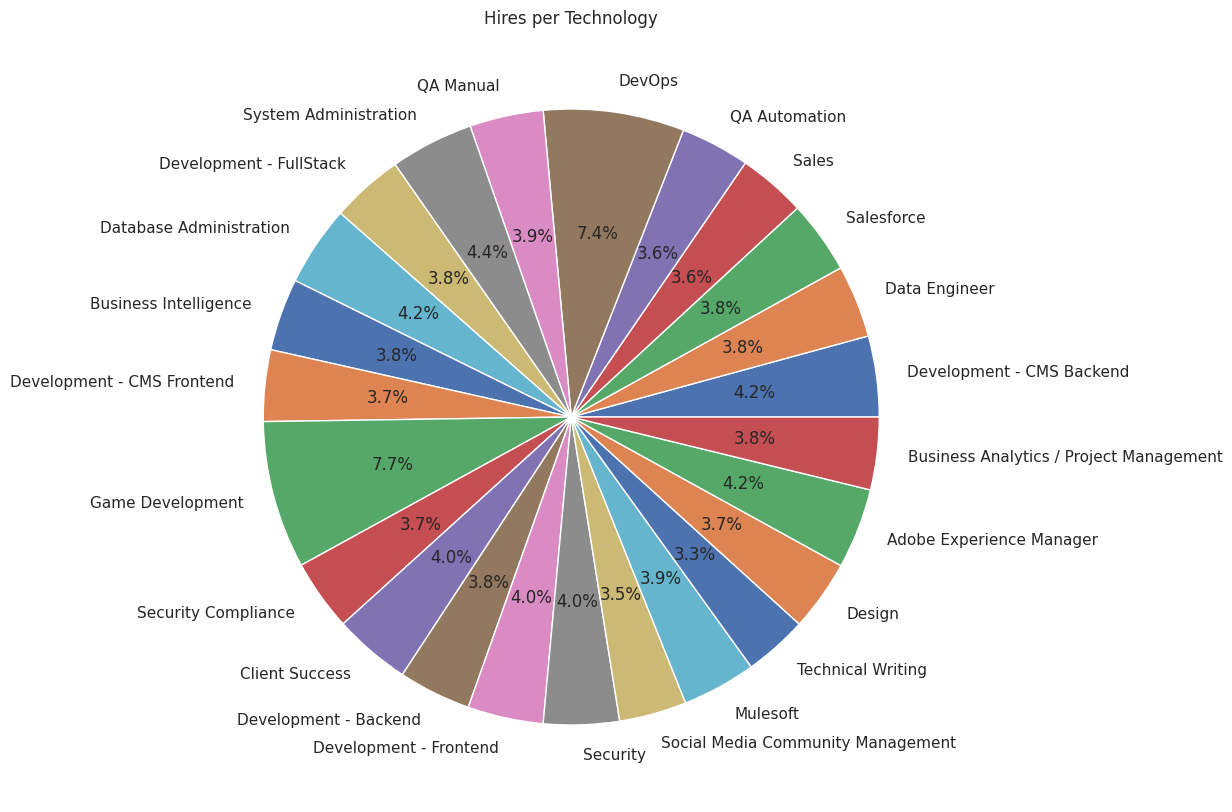

In [70]:
sns.set()
plt.figure(figsize=(10, 10))

plt.pie(
    df_hires_per_tech["hires"],
    labels=df_hires_per_tech["technology"],
    autopct="%1.1f%%",
)
plt.title("Hires per Technology")
plt.show()

In [79]:
query_hires_per_year = """
SELECT EXTRACT(YEAR FROM APPLICATION_DATE) AS YEAR, COUNT(*) AS hires
FROM FULLSTACK.CANDIDATES.CHALLENGE_SCORES
WHERE ((CODE_CHALLENGE_SCORE >= 7) AND TECHNICAL_INTERVIEW_SCORE >= 7)
GROUP BY EXTRACT(YEAR FROM APPLICATION_DATE)
order by YEAR"""

df_hires_per_year = read_from_postgres(query_hires_per_year)

/tmp/ipykernel_78035/1182849790.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql=query, con=cnx)


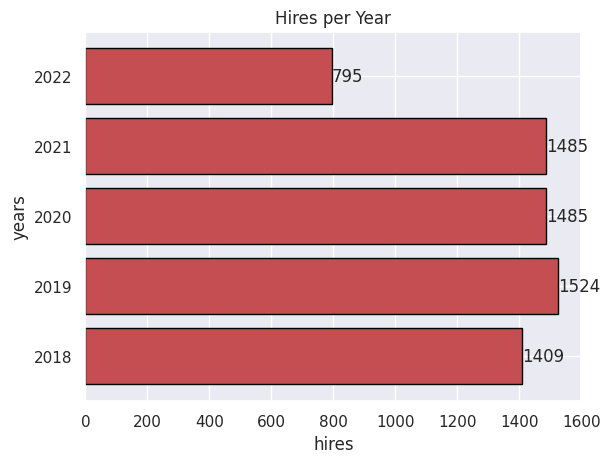

In [100]:
import matplotlib.pyplot as plt

years = [str(int(year)) for year in df_hires_per_year["year"]]
hires = df_hires_per_year["hires"].to_list()
for index, value in enumerate(hires):
    plt.text(value, index, str(value), va='center')

plt.barh(years, hires, color="r", edgecolor="black")
plt.title("Hires per Year")
plt.ylabel("years")
plt.xlabel("hires")
plt.show()

In [82]:
query_hires_by_seniority = """
SELECT SENIORITY, COUNT(*) AS hires
FROM FULLSTACK.CANDIDATES.CHALLENGE_SCORES
WHERE ((CODE_CHALLENGE_SCORE >= 7) AND TECHNICAL_INTERVIEW_SCORE >= 7)
GROUP BY SENIORITY
"""
df_hires_by_seniority = read_from_postgres(query_hires_by_seniority)

/tmp/ipykernel_78035/1182849790.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql=query, con=cnx)


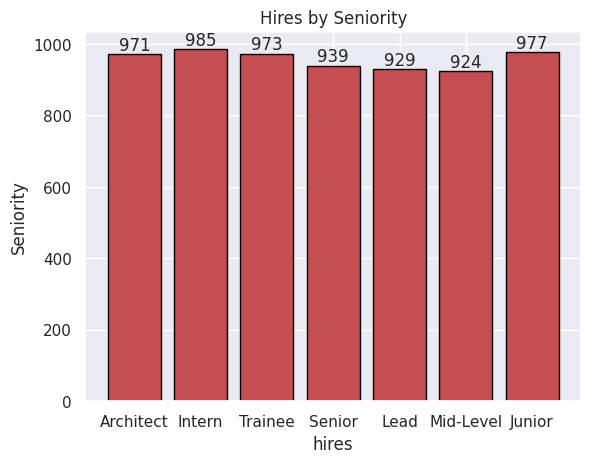

In [103]:
import matplotlib.pyplot as plt

seniority = df_hires_by_seniority["seniority"].to_list()
hires = df_hires_by_seniority["hires"].to_list()

for index, value in enumerate(hires):
    plt.text(index, value, str(value), ha='center', va='bottom')    

plt.bar(seniority, hires, color="r", edgecolor="black")
plt.title("Hires by Seniority")
plt.ylabel("Seniority")
plt.xlabel("hires")
plt.show()

In [106]:
query_hires_by_country = """
SELECT COUNTRY, EXTRACT(YEAR FROM APPLICATION_DATE) AS YEARS, COUNT(*) AS hires
FROM FULLSTACK.CANDIDATES.CHALLENGE_SCORES
WHERE ((CODE_CHALLENGE_SCORE >= 7) AND (TECHNICAL_INTERVIEW_SCORE >= 7) AND
       COUNTRY IN ('United States of America', 'Brazil', 'Colombia', 'Ecuador'))
GROUP BY COUNTRY, EXTRACT(YEAR FROM APPLICATION_DATE)
ORDER BY YEARS, COUNTRY
"""
df_hires_by_country = read_from_postgres(query_hires_by_country)

/tmp/ipykernel_78035/1182849790.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql=query, con=cnx)


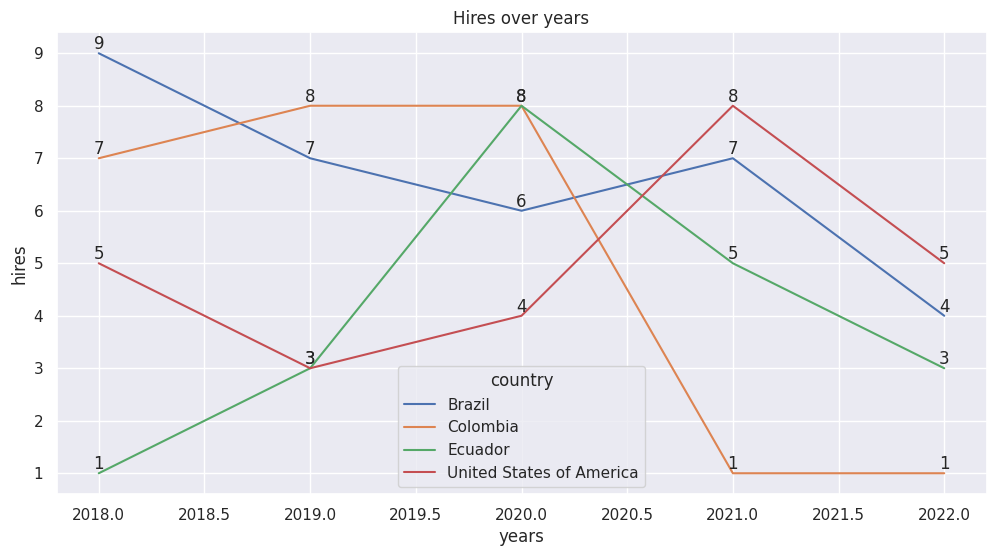

In [108]:
plt.figure(figsize=(12, 6))

df_hires_by_country["years"] = pd.to_numeric(
    df_hires_by_country["years"], downcast="integer"
)

sns.lineplot(data=df_hires_by_country, x="years", y="hires", hue="country")
#display quantity centered per year
for index, row in df_hires_by_country.iterrows():
    plt.text(row["years"], row["hires"], str(row["hires"]), ha='center', va='bottom')

plt.title("Hires over years")
plt.show()